In [1]:
import pandas as pd
import requests
import numpy as np
import datetime as datetime
from bs4 import BeautifulSoup

import time
import re

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True)

In [44]:
import codecs
f = codecs.open("cs.html", 'r', 'utf-8')
soup = BeautifulSoup(f, "html.parser")

#### Nome e ID

In [45]:
perfil = soup.find("span",{"class":"profile_small_header_name"})
nome = perfil.text
numeroId = perfil.a['href'].split("/")[-1]

#### Partidas : Mapa, Duração e Data

In [46]:
partidas =[]
for csgo_scoreboard_inner_left in soup.find_all("table",{"class":"csgo_scoreboard_inner_left"},'tbody'):
    partidas.append(csgo_scoreboard_inner_left.text)

In [47]:
mapa = []
duracao = []
data = []
inicio = time.time()

for i in range(0,len(partidas)):
    
    #MAPAS
    if len(partidas[i].split()[2]) == 10:
        mapa.append(partidas[i].split()[1])
        data.append(partidas[i].split()[2])
        duracao.append(partidas[i].split()[12])
    else:
        mapa.append(partidas[i].split()[1]+' '+partidas[i].split()[2])
        data.append(partidas[i].split()[3])
        duracao.append(partidas[i].split()[13])
fim = time.time()
print(fim - inicio)

0.003987789154052734


#### Partidas: Placar e Localização do Jogador

In [48]:
teste = []
Placar = []
Localizacao = []

inicio = time.time()
for p in soup.find_all("table",{"class":"csgo_scoreboard_inner_right banchecker-formatted"}):
    teste.append(p)
    #Criacao do Placar
    Placar.append(re.findall(r'([0-9]+\s:\s[0-9]+)',p.text)[0])
    
    #Marcar se o jogador esta na parte de cima ou de baixo da tabela resultado
    if p.text.find(re.findall(r'([0-9]+\s:\s[0-9]+)',p.text)[0]) > p.text.find(nome):
        Localizacao.append("TOP")
    else:
        Localizacao.append("BOT")
fim = time.time()
print(fim - inicio)

1.6184730529785156


#### Partidas : Ping, Vítimas, Assistencias, Mortes, % de HS e Pontos

In [49]:
ping = []
vitimas = []
assistencias = []
mortes =[]
mvp =[]
taxa_de_HS = []
pontos = []
status = []

inicio = time.time()
for registro in soup.find_all("tr",{"data-steamid64":numeroId}):
    
    #Troca o "\xa0" por 0
    p = registro.text.replace("\xa0","0")

    status.append(p)
    #ping.append(p.split()[1])
    vitimas.append(p.split()[2])
    assistencias.append(p.split()[3])
    mortes.append(p.split()[4])
    mvp.append(p.split()[5])
    taxa_de_HS.append(p.split()[6])
    pontos.append(p.split()[7])

fim = time.time()
print(fim - inicio)

0.624164342880249


#### Criação do DataFrame com os dados coletados do HTML

In [50]:
result = pd.DataFrame({'Mapa':mapa,'Duração':duracao,'Data':data,'Vitimas':vitimas,'Assistencias':assistencias,
                      ## 'Ano-Mês':'','Ano':'',
                  'Mortes':mortes,'MVP':mvp,'% de HS':taxa_de_HS,'Pontos':pontos,'Placar':Placar,'Localizacao':Localizacao,
                     'Rounds Ganhos':"",'Rounds Perdidos':"",'Rounds Jogados':'','Resultado':""})

#### Criação de novas Colunas : Rounds Ganhos, Rounds Perdidos, Resultado da partida

In [51]:
inicio = time.time()
for i in range(0,len(result)):
    if result.Localizacao[i] == "TOP":
        result['Rounds Ganhos'][i] = int(result.Placar[i].split()[0])
        result['Rounds Perdidos'][i] = int(result.Placar[i].split()[2])
    else:
        result['Rounds Ganhos'][i] = int(result.Placar[i].split()[2])
        result['Rounds Perdidos'][i] = int(result.Placar[i].split()[0])
        
    result['Rounds Jogados'][i] = result['Rounds Perdidos'][i] + result['Rounds Ganhos'][i]
    
    if result['Rounds Ganhos'][i] == 16:
        result['Resultado'][i] = 'Vitória'
    elif result['Rounds Ganhos'][i] == 15:
        result['Resultado'][i] = 'Empate'
    else:
        result['Resultado'][i] = "Derrota"
        
result.drop(['Placar','Localizacao'],axis=1,inplace=True)
fim = time.time()
print(fim - inicio)

0.285855770111084


#### Padronizando MVP e % de HS (Tirar o char ★ e a %)

In [52]:
inicio = time.time()
for i in range(0,len(result)):
    
    if len(result['% de HS'][i]) != 1:
        result['% de HS'][i] = result['% de HS'][i][:-1]
    
    if '★' in result['MVP'][i]:
        if len(result['MVP'][i]) == 1 :
            result['MVP'][i] = 1
        else:  
            result['MVP'][i]= int(result['MVP'][i][1:])
fim = time.time()
print(fim - inicio)

0.13660693168640137


#### Criar uma lista com os dados que serao transformados em float

In [53]:
inicio = time.time()
colToFloat = ['Vitimas','Assistencias','Mortes','MVP','% de HS','Pontos','Rounds Ganhos','Rounds Perdidos','Rounds Jogados']

for i in colToFloat:
    result[[i]] = result[[i]].astype(int)
fim = time.time()
print(fim - inicio)

0.018949508666992188


#### Padronizar Data

In [54]:
inicio = time.time()
result['Data'] = result['Data'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").strftime("%d-%m-%Y"))
fim = time.time()
print(fim - inicio)

0.012964963912963867


In [55]:
inicio = time.time()
result['Duração'] = result['Duração'].apply(lambda x : pd.to_timedelta('00:'+x))
fim = time.time()
print(fim - inicio)

0.01094961166381836


#### Gerar coluna de Mês e ano

In [56]:
inicio = time.time()
result['Ano-Mês'] = result['Data'].apply(lambda x : x.split('-')[2])+'-'+result['Data'].apply(lambda x : x.split('-')[1])
result['Ano'] = result['Data'].apply(lambda x : x.split('-')[2])
fim = time.time()
print(fim - inicio)

0.003962993621826172


In [57]:
result.head()

,Mapa,Duração,Data,Vitimas,Assistencias,Mortes,MVP,% de HS,Pontos,Rounds Ganhos,Rounds Perdidos,Rounds Jogados,Resultado,Ano-Mês,Ano
0,Mirage,00:42:32,27-08-2020,19,1,18,2,10,42,12,16,28,Derrota,2020-08,2020
1,Mirage,00:40:17,27-08-2020,14,2,19,2,28,34,8,16,24,Derrota,2020-08,2020
2,Overpass,00:33:54,27-08-2020,10,4,8,1,40,34,5,16,21,Derrota,2020-08,2020
3,Mirage,00:46:30,26-08-2020,17,2,21,2,35,50,16,13,29,Vitória,2020-08,2020
4,Mirage,00:41:10,26-08-2020,15,2,20,2,20,36,16,10,26,Vitória,2020-08,2020


In [58]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 15 columns):
Mapa               782 non-null object
Duração            782 non-null timedelta64[ns]
Data               782 non-null object
Vitimas            782 non-null int32
Assistencias       782 non-null int32
Mortes             782 non-null int32
MVP                782 non-null int32
% de HS            782 non-null int32
Pontos             782 non-null int32
Rounds Ganhos      782 non-null int32
Rounds Perdidos    782 non-null int32
Rounds Jogados     782 non-null int32
Resultado          782 non-null object
Ano-Mês            782 non-null object
Ano                782 non-null object
dtypes: int32(9), object(5), timedelta64[ns](1)
memory usage: 64.2+ KB


#### Gerar dummies da coluna Resultado

In [59]:
inicio = time.time()
result = pd.concat([result,pd.get_dummies(result[['Resultado']])],axis=1)
fim = time.time()
print(fim - inicio)

0.0069582462310791016


#### Gerar lista com o nome dos mapas e lista de colunas

In [60]:
lista_mapas = result.Mapa.unique().tolist()

In [61]:
lista_mapas

['Mirage', 'Overpass', 'Inferno', 'Dust II', 'Cache', 'Cobblestone']

In [62]:
result.describe().columns.tolist()

['Duração',
 'Vitimas',
 'Assistencias',
 'Mortes',
 'MVP',
 '% de HS',
 'Pontos',
 'Rounds Ganhos',
 'Rounds Perdidos',
 'Rounds Jogados',
 'Resultado_Derrota',
 'Resultado_Empate',
 'Resultado_Vitória']

In [63]:
list_colunas = result.describe().columns.tolist()

In [64]:
col_para_soma = result.drop(['Duração','% de HS'],axis=1).describe().columns.tolist()
col_para_media = result.drop(['Duração'],axis=1).describe().columns.tolist()

#### df agrupamento por soma e media

In [65]:
inicio = time.time()
map_media = result.groupby('Mapa')[list_colunas].mean().round(2)
fim = time.time()
print(fim - inicio)

0.007979631423950195


In [66]:
map_media

,Vitimas,Assistencias,Mortes,MVP,% de HS,Pontos,Rounds Ganhos,Rounds Perdidos,Rounds Jogados,Resultado_Derrota,Resultado_Empate,Resultado_Vitória
Mapa,,,,,,,,,,,,
Cache,15.34,4.22,17.30,2.08,33.62,42.56,12.98,12.86,25.84,0.44,0.16,0.40
Cobblestone,13.00,6.00,19.00,1.00,61.00,34.00,16.00,12.00,28.00,0.00,0.00,1.00
Dust II,16.38,3.69,18.08,2.15,29.46,40.46,15.15,10.69,25.85,0.15,0.00,0.85
Inferno,15.33,4.00,17.78,1.67,28.69,39.72,12.86,12.97,25.83,0.42,0.11,0.47
Mirage,14.75,4.28,17.43,1.79,28.31,39.57,13.12,12.47,25.59,0.43,0.10,0.47
Overpass,15.79,4.23,17.83,2.13,25.29,41.40,13.30,13.17,26.47,0.41,0.11,0.47


In [67]:
inicio = time.time()
map_soma = result.groupby('Mapa')[result.drop(['% de HS'],axis=1).describe().columns.tolist()].sum()
fim = time.time()
print(fim - inicio)

0.03487968444824219


In [68]:
map_contagem = result.groupby('Mapa')['Mapa'].count()

#### Criando DF informações Gerais

In [69]:
dfif = pd.DataFrame(result[list_colunas].sum()).T

In [70]:
dfif

,Duração,Vitimas,Assistencias,Mortes,MVP,% de HS,Pontos,Rounds Ganhos,Rounds Perdidos,Rounds Jogados,Resultado_Derrota,Resultado_Empate,Resultado_Vitória
0,22 days 19:12:49,11680,3324,13672,1437,22253,31233,10286,9816,20102,330,82,370


In [71]:
dfif = dfif.drop(['% de HS'],axis=1)

In [72]:
inicio = time.time()
dfif['Jogo mais Recente'] = result['Data'][0]
dfif['Jogo mais Antigo'] = result['Data'][result.shape[0]-1]
dfif['Quantidade de Jogos'] = result.shape[0]
dfif['% de HS'] = format(round(result['% de HS'].mean(),2))+" %"
fim = time.time()
print(fim - inicio)

0.003991127014160156


In [73]:
dfif.columns.tolist()

['Duração',
 'Vitimas',
 'Assistencias',
 'Mortes',
 'MVP',
 'Pontos',
 'Rounds Ganhos',
 'Rounds Perdidos',
 'Rounds Jogados',
 'Resultado_Derrota',
 'Resultado_Empate',
 'Resultado_Vitória',
 'Jogo mais Recente',
 'Jogo mais Antigo',
 'Quantidade de Jogos',
 '% de HS']

In [74]:
dfif = dfif[['Quantidade de Jogos',
 'Jogo mais Antigo',
 'Jogo mais Recente',
 'Duração',
 'Vitimas',
 'Assistencias',
 'Mortes',
 'MVP',
 'Pontos',
 '% de HS',
 'Rounds Jogados',
 'Rounds Ganhos',
 'Rounds Perdidos',
 'Resultado_Derrota',
 'Resultado_Empate',
 'Resultado_Vitória']]

In [75]:
dfif = dfif.T.rename(columns={0: ""})

In [76]:
dfif

,
Quantidade de Jogos,782
Jogo mais Antigo,06-11-2017
Jogo mais Recente,27-08-2020
Duração,22 days 19:12:49
Vitimas,11680
Assistencias,3324
Mortes,13672
MVP,1437
Pontos,31233
% de HS,28.46 %


In [77]:
def somaColuna (x):
    return x.sum() 

def mediaColuna(x):
    return x.sum()/x.shape[0]

def mediaRound(x):
    return x.sum()/result['Rounds Jogados'].sum()

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
#result.set_index('Data', inplace=True)
result.groupby('Ano')['Pontos'].sum()

Ano
2017       40
2018     9821
2019     3303
2020    18069
Name: Pontos, dtype: int32

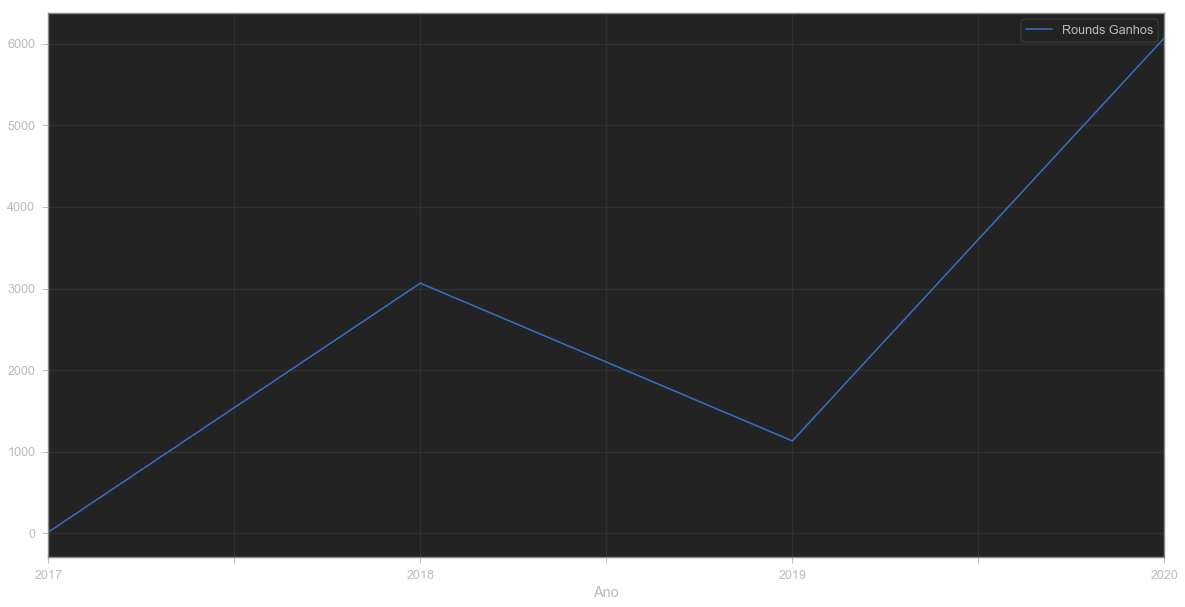

In [80]:
plt.figure(figsize=(20,10))
ax = result.groupby('Ano')['Rounds Ganhos'].sum().plot(legend=True)

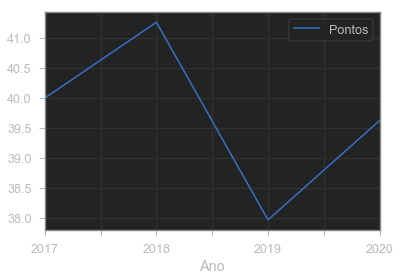

In [81]:
ax = result.groupby('Ano')['Pontos'].mean().plot(legend=True)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 <a list of 10 Text xticklabel objects>)

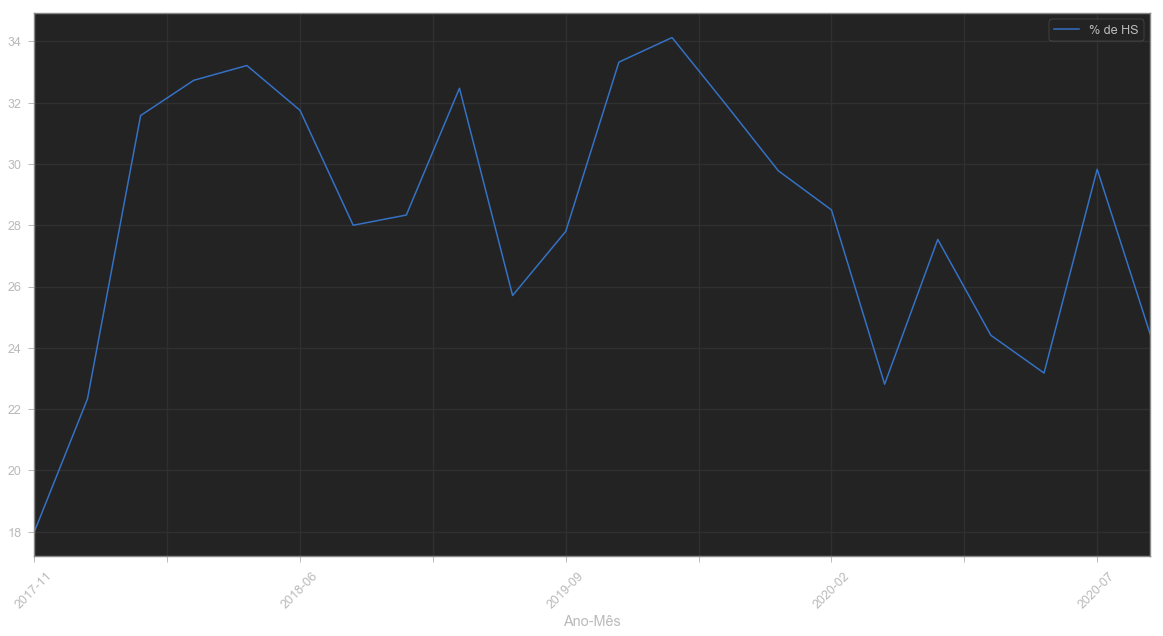

In [82]:
plt.figure(figsize=(20,10))
ax = result.groupby('Ano-Mês')['% de HS'].mean().plot(legend=True)
plt.xticks(rotation=45)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 <a list of 10 Text xticklabel objects>)

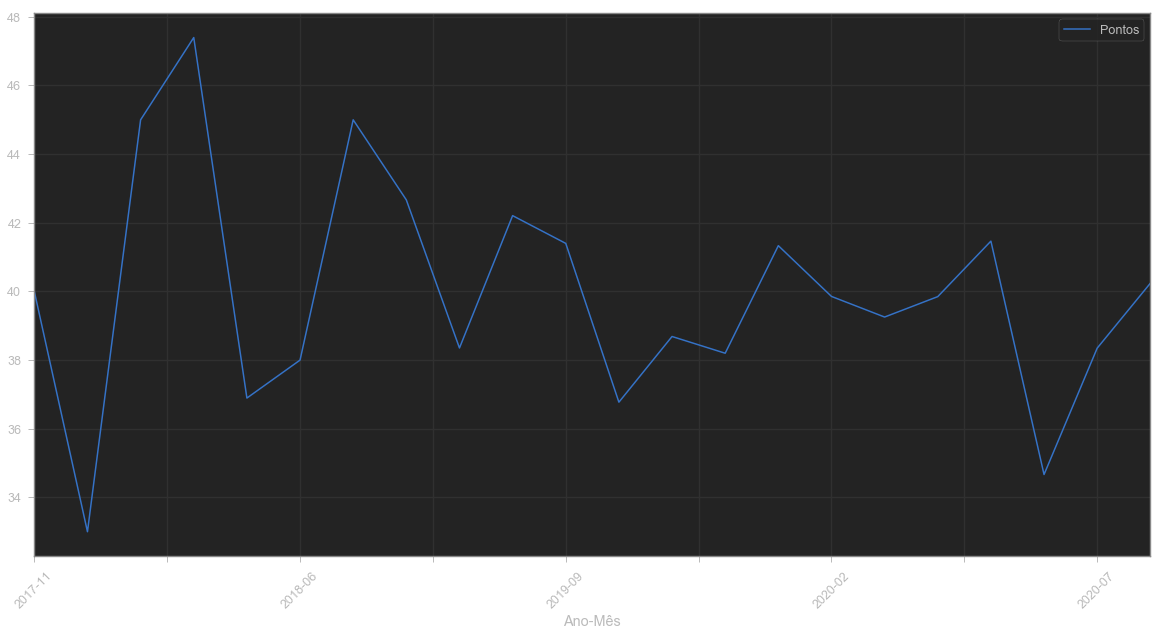

In [83]:
plt.figure(figsize=(20,10))
ax = result.groupby('Ano-Mês')['Pontos'].mean().plot(legend=True)
plt.xticks(rotation=45)

In [84]:
result.values[0]

array(['Mirage', Timedelta('0 days 00:42:32'), '27-08-2020', 19, 1, 18, 2,
       10, 42, 12, 16, 28, 'Derrota', '2020-08', '2020', 1, 0, 0],
      dtype=object)

In [87]:
result.to_csv("csgo.csv")